In [107]:
import os

os.chdir('C:/MSBA/Summer 2020/2205-INSY-5378-Data Science/Project')

In [108]:
import pandas as pd

dataset_df = pd.read_csv('dataset.csv')
x_dataset = dataset_df.drop('target', axis=1).values
y_dataset = dataset_df['target'].values

print('Dataset shape: ', dataset_df.shape, '\n')
dataset_df.info()

Dataset shape:  (1306122, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [4]:
dataset_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
                        train_test_split(x_dataset, y_dataset, test_size = 0.20, stratify = y_dataset, random_state = 32)

print('x_train shape :', x_train.shape)
print('x_test shape  :', x_test.shape)
print('y_train shape :', y_train.shape)
print('y_test shape  :', y_test.shape)

x_train shape : (1044897, 2)
x_test shape  : (261225, 2)
y_train shape : (1044897,)
y_test shape  : (261225,)


Target counts in Dataset set:
0:  1225312
1:  80810


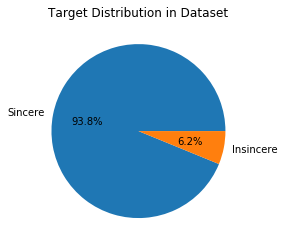

Target counts in Training set:
0:  980249
1:  64648


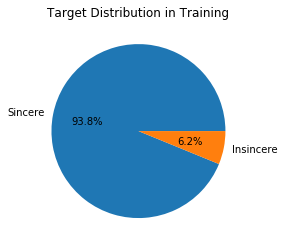

Target counts in Test set:
0:  245063
1:  16162


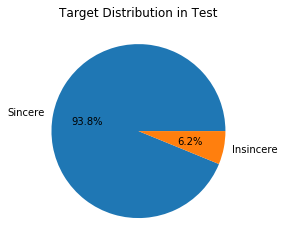

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def target_distribution(array, data):
    ones = np.count_nonzero(array)
    zeros = len(array) - ones
    print('Target counts in {} set:'.format(data))
    print('0: ', zeros)
    print('1: ', ones)

    plt.pie([zeros, ones], labels = ['Sincere', 'Insincere'], autopct='%.1f%%')
    plt.title('Target Distribution in {}'.format(data))
    plt.show()

target_distribution(dataset_df['target'], 'Dataset')
target_distribution(y_train, 'Training')
target_distribution(y_test, 'Test')

In [27]:
def preprocess(array, table, stopwords, lemmatizer):
    
    for i in range(len(array)):
        text = array[i, 1]

        # convert to lower case and remove punctuation & digits 
        text = text.lower().translate(table)

        #remove stopwords and lemmatize the word
        word_list = [lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords]

        text = " ".join(word_list)
        array[i, 1] = text

    return(array)    

In [28]:
import string
import nltk

# for removing punctuations and digits
exclude = string.punctuation + string.digits
table = str.maketrans(exclude, len(exclude) * " ")

# for removing stopwords 
stopwords = nltk.corpus.stopwords.words('english')

# Instantiate Lemmatizer 
lemmatizer = nltk.stem.WordNetLemmatizer() 

array = x_train.copy()
x_train_pp = preprocess(array, table, stopwords, lemmatizer)

array = x_test.copy()
x_test_pp = preprocess(array, table, stopwords, lemmatizer)

In [55]:
print(x_train_pp[:10, 1],'\n')
print(x_test_pp[:10, 1])

['join nlsiu age five year course' 'fanacially freedom'
 'meaning ligamentum flavum hypertrophy'
 'sephardic jew integrated host gentile society ashkenazi jew would'
 'processor join ncc junior study'
 'three piece advice would give college student want become entrepreneur'
 'legal system prevent spouse child testifying spouse parent rationale'
 'father name' 'key fact life would tell someone order maximise happiness'
 'good teen writer quora'] 

['best melody'
 'racist united state know racist think right donald trump acknowledge'
 'best photo shopped picture seen' 'solve inequality x x'
 'relationship faith reason islam' 'give strategy use academic reading'
 'ordinary citizen india control population growth'
 'people belief christianity islam begun fall information internet'
 'best artificial intelligence startup mangalore'
 'nigeria government insensitive plight people']


In [89]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(x_train_pp[:,1])
#features_train_dense = features_train.todense()

In [90]:
def report_metrics(y_test, y_pred, y_pred_prob):
    print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
    print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print('\nClassification Report:\n ', classification_report(y_test, y_pred, target_names = ['Sincere', 'Insincere']))

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    area = auc(recall, precision)

    plt.plot(recall, precision, label = 'P-R curve')
    plt.legend(loc = 'lower left')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.1, 1.0])
    plt.ylim([0.1, 1.1])
    plt.title('P-R curve with Area Under Curve: {:0.2f}'.format(area))
    plt.show()

Accuracy Score: 0.9353813762082496

Confusion Matrix:
 [[234283  10780]
 [  6100  10062]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.97      0.96      0.97    245063
   Insincere       0.48      0.62      0.54     16162

    accuracy                           0.94    261225
   macro avg       0.73      0.79      0.75    261225
weighted avg       0.94      0.94      0.94    261225



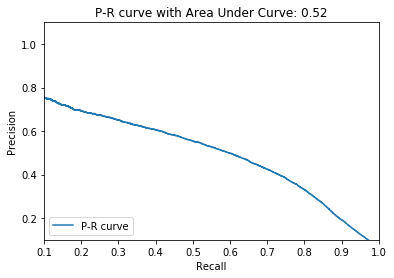

In [91]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, auc

model = MultinomialNB()
model.fit(features_train, y_train)

features_test = vectorizer.transform(x_test_pp[:,1])
#features_test_dense = features_test.todense()

y_pred = model.predict(features_test)
y_pred_prob = model.predict_proba(features_test)[:, 1]

report_metrics(y_test, y_pred, y_pred_prob)

In [97]:
def model_optimization(steps, parameters):
    
    # Create the pipeline 
    pipeline = Pipeline(steps)

    # Create the RandomizedSearchCV object: model_cv
    model_cv = RandomizedSearchCV(estimator = pipeline, param_distributions = parameters, 
                                  cv = 5, random_state = 337, scoring = 'f1')

    # Fit to the training set
    model_cv.fit(x_train_pp[:,1], y_train)

    # Compute and print the metrics
    print("Tuned best parameters: {}".format(model_cv.best_params_))

    # Predit on the test set using best parameters 
    y_pred = model_cv.predict(x_test_pp[:,1])
    y_pred_prob = model_cv.predict_proba(x_test_pp[:,1])[:,1]
    
    # Generate the metrics to evaluate model performance
    report_metrics(y_test, y_pred, y_pred_prob)

Tuned best parameters: {'vectorizer__ngram_range': (1, 2), 'model_mnb__class_prior': None, 'model_mnb__alpha': 0.2}
Accuracy Score: 0.9319513829074553

Confusion Matrix:
 [[232620  12443]
 [  5333  10829]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.98      0.95      0.96    245063
   Insincere       0.47      0.67      0.55     16162

    accuracy                           0.93    261225
   macro avg       0.72      0.81      0.76    261225
weighted avg       0.95      0.93      0.94    261225



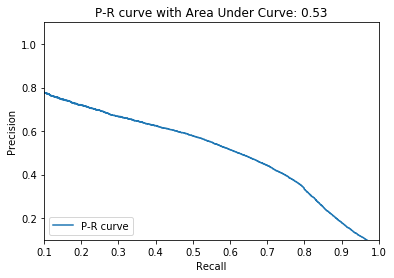

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Specify the pipeline steps
steps = [('vectorizer', CountVectorizer()), ('model_mnb', MultinomialNB())]

# Specify the hyperparameter space
parameters = {'vectorizer__ngram_range':[(1,1),(1,2),(2,2)], 
              'model_mnb__alpha': np.linspace(0.1,1,10), 'model_mnb__class_prior' : [None, [.06, .94], [.5, .5]]}

model_optimization(steps, parameters)

In [100]:
model_cv.cv_results_

{'mean_fit_time': array([25.19484906, 10.1735961 , 31.07770462, 31.57418766, 24.84318223,
        24.98620014, 32.08024888, 10.26036911, 25.87351918, 10.74826336]),
 'std_fit_time': array([0.71663336, 0.34091959, 0.3305779 , 0.75103776, 0.29587405,
        0.42274506, 0.22616772, 0.37506824, 0.87782898, 0.46717062]),
 'mean_score_time': array([3.27923498, 2.37963901, 4.68128538, 4.61725554, 3.31613593,
        3.32571001, 4.78022051, 2.48076787, 3.43840752, 2.7119555 ]),
 'std_score_time': array([0.16732841, 0.13480926, 0.19815187, 0.14692442, 0.1819779 ,
        0.15803124, 0.22869967, 0.16944091, 0.15591229, 0.26258252]),
 'param_vectorizer__ngram_range': masked_array(data=[(2, 2), (1, 1), (1, 2), (1, 2), (2, 2), (2, 2), (1, 2),
                    (1, 1), (2, 2), (1, 1)],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_model_mnb__class_prior': masked_array(data=

In [104]:
from sklearn.neighbors import KNeighborsClassifier

# Specify the pipeline steps
steps = [('vectorizer', CountVectorizer()), ('model_knn', KNeighborsClassifier())]

# Specify the hyperparameter space
parameters = {'vectorizer__ngram_range':[(1,1),(1,2),(2,2)], 
              'model_knn__n_neighbors': list(range(5,30)), 'model_knn__weights': ['uniform', 'distance']}

model_optimization(steps, parameters)

KeyboardInterrupt: 

Tuned best parameters: {'vectorizer__ngram_range': (1, 2), 'model_mnb__class_prior': [0.5, 0.5], 'model_mnb__alpha': 1.0}
Accuracy Score: 0.9368628576897311

Confusion Matrix:
 [[237034   8029]
 [  8464   7698]]

Classification Report:
                precision    recall  f1-score   support

     Sincere       0.97      0.97      0.97    245063
   Insincere       0.49      0.48      0.48     16162

    accuracy                           0.94    261225
   macro avg       0.73      0.72      0.72    261225
weighted avg       0.94      0.94      0.94    261225



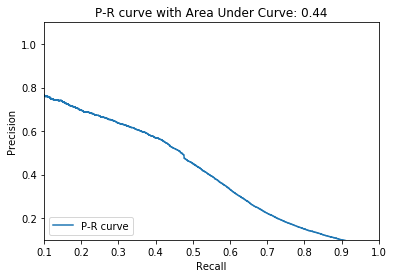

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

steps = [('vectorizer', CountVectorizer()), ('model_mnb', MultinomialNB())]

# Create the pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'vectorizer__ngram_range':[(1,2)], 
              'model_mnb__alpha': np.linspace(0.1,1,10), 'model_mnb__class_prior' : [[.5, .5]]}

# Create the RandomizedSearchCV object: model_cv
model_cv = RandomizedSearchCV(estimator = pipeline, param_distributions = parameters, cv = 5)

# Fit to the training set
model_cv.fit(x_train_pp[:,1], y_train)

# Compute and print the metrics
print("Tuned best parameters: {}".format(model_cv.best_params_))

# Predit on the test set using best parameters  
y_pred = model_cv.predict(x_test_pp[:,1])
y_pred_prob = model_cv.predict_proba(x_test_pp[:,1])[:,1]

# Generate the metrics to evaluate model performance
report_metrics(y_test, y_pred, y_pred_prob)

In [84]:
acc = model_cv.score(x_test_pp[:,1], y_test)
print("Tuned accuracy: {}".format(acc))
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.9465326825533544


In [77]:
steps = [('imputation', Imputer(missing_values='NaN', strategy='mean', axis=0)),
         ('scaler', StandardScaler()),
         ('elasticnet',ElasticNet())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline,param_grid=parameters)

# Fit to the training set
gm_cv.fit(X_train,y_train)

# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))

NameError: name 'Imputer' is not defined

In [ ]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
p_grid_NB = {'alpha': alphas, 'fit_prior' : [True, False], 'class_prior' : [None, [.1,.9],[.2, .8]]}

NB_cls= MultinomialNB()

grid = GridSearchCV(estimator = NB_cls, param_grid = p_grid_NB, scoring = 'roc_auc', cv = 5)
grid.fit(Train_X, Train_y)

In [106]:
c_space = np.logspace(-5, 8, 15)
c_space

array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])

In [ ]:
# Specify the pipeline steps
steps = [('vectorizer', CountVectorizer()), ('model_lr', LogisticRegression(random_state = 337, max_iter = 1000))]

# Specify the hyperparameter space
parameters = {'vectorizer__ngram_range': [(1,1),(1,2),(1,3)], 
              'model_lr__penalty' : {'l1','l2','elasticnet'},
              'model_lr__C' : np.logspace(-5, 8, 15),
              'model_lr__class_weight': [None, 'balanced', {0: 0.06, 1: .94}, {0: 1, 1: 100}, {0: 100, 1: 1}],
              'model_lr__solver': {'lbfgs', 'liblinear', 'saga'}, 
              'model_lr__l1_ratio': np.linspace(0,1,30) 
             }
             
model_lr_hyper = model_optimization(steps, parameters)

Target counts in dataset after Under Sampling set:
0:  80810
1:  80810


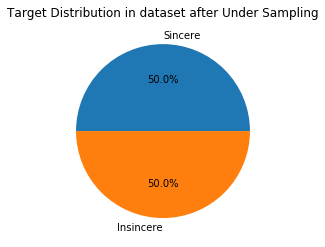

In [114]:
from imblearn.under_sampling import RandomUnderSampler 

sampler = RandomUnderSampler(random_state = 32)
x_resampled, y_resampled = sampler.fit_sample(x_dataset, y_dataset)

target_distribution(y_resampled, 'dataset after Under Sampling')

Target counts in Training after Under Sampling set:
0:  64648
1:  64648


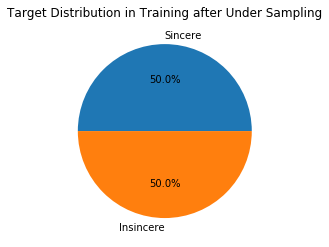

Target counts in Test after Under Sampling set:
0:  16162
1:  16162


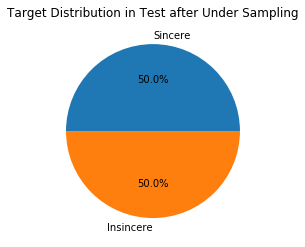

In [115]:
x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x_resampled, y_resampled, 
                                                                test_size = 0.20, stratify = y_resampled, random_state = 32)

target_distribution(y_train_us, 'Training after Under Sampling')
target_distribution(y_test_us, 'Test after Under Sampling')

In [116]:
array = x_train_us.copy()
x_train_us_pp = preprocess(array, table, stopwords, lemmatizer)

array = x_test_us.copy()
x_test_us_pp = preprocess(array, table, stopwords, lemmatizer)

In [118]:
print(x_resampled.shape)
print(y_resampled.shape)
print(x_dataset.shape)
print(y_dataset.shape)

dataset_array = np.hstack([x_dataset, y_dataset.reshape(-1,1)])
resampled_array = np.hstack([x_resampled, y_resampled.reshape(-1,1)])

print(dataset_array.shape)
print(resampled_array.shape)

(161620, 2)
(161620,)
(1306122, 2)
(1306122,)
(1306122, 3)
(161620, 3)


In [120]:
temp = [i for i in dataset_array if i not in resampled_array]

KeyboardInterrupt: 

In [121]:
dataset_df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [122]:
resampled_df = pd.DataFrame(resampled_array, columns = dataset_df.columns)
resampled_df

,qid,question_text,target
0,57f0bb7c4bb0054a5697,When was the last iPhone 4 update?,0
1,5cd0e1b74558143f3431,How do I fix my iMessage?,0
2,2f7c2da305a35658e471,How is Samsung Note 8?,0
3,082324ed1693994ff9df,Why is my background check taking so long? I a...,0
4,ccfadec167dad09d77c4,How do I learn to love my brother? We have a r...,0
...,...,...,...
161615,fffeba722d9b371bd1b9,How is it to have intimate relation with your ...,1
161616,fffee269360dd0d3947a,Why is it when singers have lyrics about voice...,1
161617,ffff0e4ea1bb6e16feec,Do pakis smell of curry and shit?,1
161618,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1


In [139]:
temp_df = pd.merge(dataset_df, resampled_df, how = 'left', indicator = 'true')
temp_df

,qid,question_text,target,true
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,left_only
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,left_only
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,both
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,left_only
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,left_only
...,...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0,left_only
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0,left_only
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0,left_only
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0,left_only


In [150]:
dropped_df = temp_df.loc[temp_df['true'] == 'left_only', temp_df.columns[:-1]]
dropped_df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


(1144502, 3)

In [154]:
dropped_df

,qid,question_text,target
0,00002165364db923c7e6,quebec nationalist see province nation,0
1,000032939017120e6e44,adopted dog would encourage people adopt shop,0
3,000042bf85aa498cd78e,otto von guericke used magdeburg hemisphere,0
4,0000455dfa3e01eae3af,convert montra helicon mountain bike changing ...,0
5,00004f9a462a357c33be,gaza slowly becoming auschwitz dachau treblink...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,technical skill need computer science undergra...,0
1306118,ffffd431801e5a2f4861,m ece good job prospect usa like india job pre...,0
1306119,ffffd48fb36b63db010c,foam insulation toxic,0
1306120,ffffec519fa37cf60c78,one start research project based biochemistry ...,0


In [152]:
def preprocess(array):
    
    # for removing punctuations and digits
    exclude = string.punctuation + string.digits
    table = str.maketrans(exclude, len(exclude) * " ")

    # for removing stopwords 
    stopwords = nltk.corpus.stopwords.words('english')

    # Instantiate Lemmatizer 
    lemmatizer = nltk.stem.WordNetLemmatizer()

    for i in range(len(array)):
        text = array[i, 1]

        # convert to lower case and remove punctuation & digits 
        text = text.lower().translate(table)

        #remove stopwords and lemmatize the word
        word_list = [lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords]

        text = " ".join(word_list)
        array[i, 1] = text

    return(array)

In [ ]:
# Collect the dropped records by under sampler to be used for scoring purposes
# Note: only those records with Target value '0' (i.e Sincere) were dropped by under sampler 

resampled_array = np.hstack([x_resampled, y_resampled.reshape(-1,1)])
resampled_df = pd.DataFrame(resampled_array, columns = dataset_df.columns)

temp_df = pd.merge(dataset_df, resampled_df, how = 'left', indicator = 'true')
dropped_df = temp_df.loc[temp_df['true'] == 'left_only', temp_df.columns[:-1]]

dropped_df.shape

In [153]:
# Set up the x and y for scoring dataset
x_score = dropped_df.drop('target', axis=1).values
y_score = dropped_df['target'].values

# Preprocess the x_score prior to passing it to model 
array = x_score
x_score_pp = preprocess(array)

# Use the best fit model and predict on the dropped dataset to obtain predicted and probabilities for target variable
y_pred = model_lr_hyper.predict(x_score_pp[:,1])
y_pred_prob = model_lr_hyper.predict_proba(x_score_pp[:,1])[:,1]

# Generate the metrics to evaluate model performance for generalization 
report_metrics(y_score, y_pred, y_pred_prob, pred_prob = True)

In [ ]:
# Note: as there are only records belonging to 1 class in target variable, accuracy_score is displaying below error: 
# Classification metrics can't handle a mix of unknown and binary targets 

# Hence setting the first record in the array to 1, so that target variable has 2 class representation
#y_score[0] = 1
